# Lab 9: Audio Classification 

In [1]:
import numpy as np
from scipy.io.wavfile import read
from scipy import signal
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import copy
import warnings
import random
from scipy.stats import multivariate_normal as mvn
import librosa
%matplotlib inline
warnings.filterwarnings("ignore")

## Part 1: Making a speech detector

In this section we will design a simple classifier that will let us know if its input is speech or non-speech. Download the data archive from: [ https://drive.google.com/file/d/1oAnvk-hzzgzZ4di4W0pKw6v3IWLm9u2X/view?usp=sharing ] In this part we will use the dataset in data/SpeechMusic. In it you will find two directories, speech/ and music/ containing data from each class.

Randomly select 50 soundfiles from each directory to use as training data, and use the remaining sounds as testing data. For all of the sounds we will compute a representation that makes the classification easier and we will use a simple Gaussian model to classify them. Do the following:

- Perform an STFT for each sound, take it’s magnitude and raise it to 0.3 to improve contrast
    - We will consider each spctral slice of that to be a data point
- Using the training data of each sound:
    - Calculate the mean column and the diagonal covariance of the columns
    - You will thus get two sets of Gaussian parameters that model each sound class
- For each testing data point:
    - Calculate the likelihood of each column based on the above models
	- To calculate the entire file likelihood add all the frame likelihoods
	- Assign each soundfile to the class that gets the highest likelihood

For extra credit implement the parameter estimation and model likelihood yourself. If you are too lazy for that you can instead use ```sklearn.mixture.GaussianMixture``` to learn a diagonal single-Gaussian model per class.

How do the results look like? If you rerun this with a different training/testing set, is there an appreciable difference? On average over multiple training/testing sets what accuracy do you get?

In [2]:
def get_stft(x, dft_size=256, hop_size=256, zero_pad=0, window='hanning'):
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
    L = len(x)
    num_frame = (L-dft_size)//hop_size
    tail = L-(num_frame*hop_size+dft_size)
    if tail>0:
        pad = hop_size-tail
        x = np.pad(x, (0,pad), 'constant')
        num_frame += 1
    stft = np.zeros((num_frame, int((dft_size+zero_pad)/2)+1)).astype(complex)
    for i, t in enumerate(stft[:]):
        input_f = x[i*hop_size:i*hop_size+dft_size].astype(float)
        input_f *= w(len(input_f))
        input_f = np.pad(input_f, (0, zero_pad), 'constant')    
        stft[i] = np.fft.rfft(input_f)
    stft = abs(stft)**.3
    return stft

class classifier(object):  
    def load(self, data, shuffle=True, perc=None, feature_type='stft'):
        if shuffle:
            random.shuffle(data)
        self.test_data = []
        temp = []
        for i, d in enumerate(data):
            x, fs = librosa.load(d)
            x = x.astype(float)/max(x)
            
            if feature_type =='stft':
                feature = get_stft(x)
            elif feature_type =='mfcc':
                feature = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=80)[2:13, :]
                feature = feature.T
            else:
                raise ValueError("Wrong feature type.")
                
            if not perc:
                if i<50:
                    temp.append(feature)
                else:
                    self.test_data.append(feature)
            else:
                if i<int(perc*len(data)):
                    temp.append(feature)
                else:
                    self.test_data.append(feature)    
        self.train_data = np.vstack(tuple(temp))

    def train(self):
        self.mean = np.mean(self.train_data, axis=0)
        self.cov = np.cov(self.train_data, rowvar=False)

    def test(self, x):
        p = mvn.logpdf(x, self.mean, self.cov)
        return sum(p)
# Code Reference: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
# The code in this cell is slightly modified for the actual implementation

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#              rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_conf_mat(conf_mat, labels, title, size=4):
    fig, ax = plt.subplots(figsize=(size,size))
    true_label = pred_label = labels
    im, cbar = heatmap(conf_mat, true_label, pred_label, ax=ax, cmap="YlGn", cbarlabel="number of samples")
    texts = annotate_heatmap(im)
    fig.tight_layout()
    plt.title(title)
    plt.xlabel('true labels')
    plt.ylabel('predicting labels')
    plt.show()

### Gaussian Model

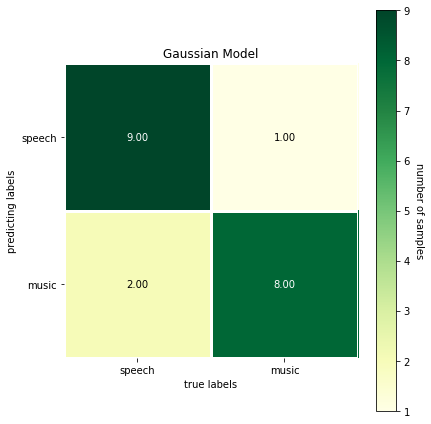

In [3]:
# YOUR CODE HERE
# raise NotImplementedError()
types = ['speech','music']
paths = []
sm_classifiers = {}
for t in types:
    p = []
    for f in os.listdir('data/SpeechMusic/'+t):
        p.append('data/SpeechMusic/'+t+'/'+f)
    paths.append(p)
    sm_classifiers[t] = classifier()
    
for p, t in zip(paths, types):
    sm_classifiers[t].load(p)
    sm_classifiers[t].train()
    
conf_mat = np.zeros((len(types), len(types)))
for i, t in enumerate(types):
    test_data = sm_classifiers[t].test_data
    for d in test_data:
        p = [sm_classifiers[i].test(d) for i in types]
        j = np.argmax(p)
        conf_mat[i, j] += 1
        
plot_conf_mat(conf_mat, types, 'Gaussian Model', size=6)

Each time we run the code, the dataset is randomly shuffled before splitting into training and testing sets. After running the model a few times, it can be seen that the accuracy is about 80% for this task.

## Part 2: Making a music genre classifier

We will repeat the above, but this time we will perform music genre classification. To do so we will use a slightly more elaborate feature representation, and a stronger classification model. If you downloaded the data archive pointed to above, you will find a subset of the CTZAN dataset in the data/genre folder, this is a benchmark data set for music genre classification.

Just as before, you will find a set of directories with examples of each sound class that we want to recognize. For each class, split the soundfiles into a training set (50% of data) and testing set (remaining 50% of data).

For a representation we will use MFCC features. For extra credit, code these yourself otherwise you can use the implementation from the ```librosa``` library. Once all the files are transformed we will have a series of MFCC frames for each recording (as opposed to spectral frames as is in the case of the STFT). We will use these as the data to classify.

For each class learn a Gaussian model (with a diagonal covariance again). This will be the same process as above.
In order to evaluate how good this works we will use the following procedure. For each sound in the training data, get the likelihood of each MFCC frame based on the learned Gaussian models and sum these over the entire file just as we did before. Use the resulting values to get a classification result for each . Report how accurate your results are. Now report the accuracy using your testing data instead.

Now will use a better classifier to hopefully get better accuracy. We will use a Gaussian Mixture Model (```sklearn.mixture.GaussianMixture```). Just as before you should learn one such model for each class using the corresponding training data.

How many Gaussians do you need in your GMM to get the best results? Do the MFCC parameters make a difference? Play around with the numbers to get the best possible results.

### Gaussian Model

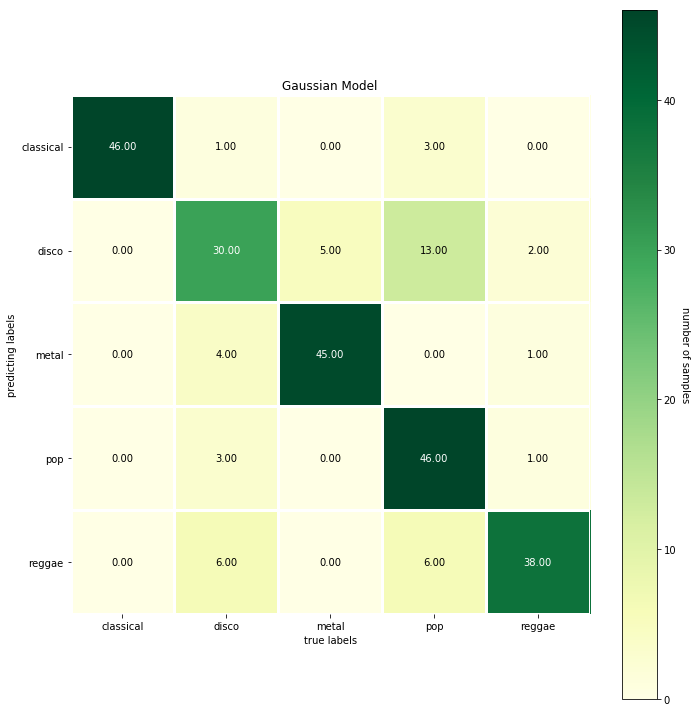

In [14]:
# YOUR CODE HERE
# raise NotImplementedError()
genres = ['classical','disco','metal','pop','reggae']
paths = []
g_classifiers = {}
for g in genres:
    p = []
    for f in os.listdir('data/genres/'+g):
        p.append('data/genres/'+g+'/'+f)
    paths.append(p)
    g_classifiers[g] = classifier()
    
for p, g in zip(paths, genres):
    g_classifiers[g].load(p, perc=0.5, feature_type='mfcc')
    g_classifiers[g].train()
    
conf_mat = np.zeros((len(genres), len(genres)))
for i, g in enumerate(genres):
    test_data = g_classifiers[g].test_data
    for d in test_data:
        p = [g_classifiers[i].test(d) for i in genres]
        j = np.argmax(p)
        conf_mat[i, j] += 1
        
plot_conf_mat(conf_mat, genres, 'Gaussian Model', size=10)

### Gaussian Mixture Models

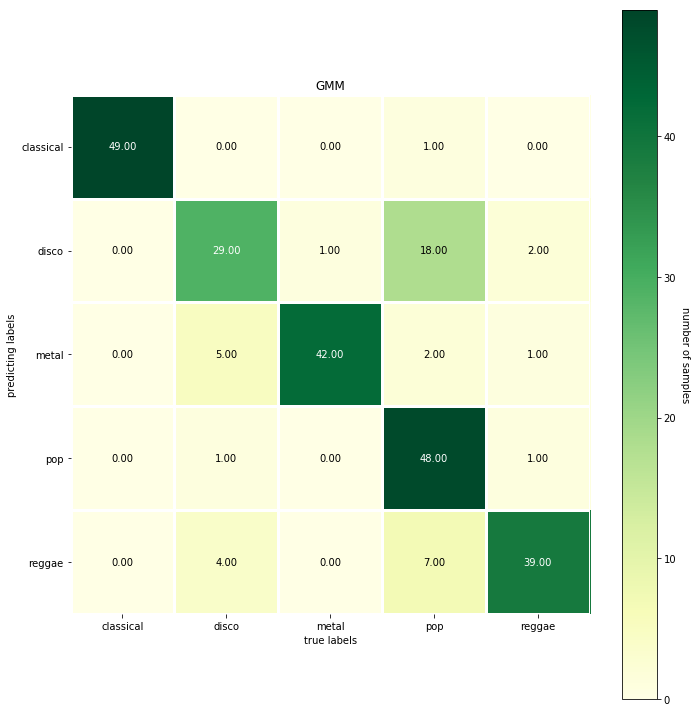

In [15]:
from sklearn import mixture

gmms = [mixture.GaussianMixture(n_components=10) for _ in range(len(genres))]
for i, g in enumerate(genres):
    d = g_classifiers[g].train_data
    gmms[i].fit(np.array(d))

conf_mat = np.zeros((len(genres), len(genres)))
for i, g in enumerate(genres):
    test_data = g_classifiers[g].test_data
    for d in test_data:
        scores = [gmms[i].score_samples(d) for i in range(len(genres))]
        p = np.argmax(scores, axis=0)
        j = np.bincount(p).argmax()
        conf_mat[i, j] += 1
        
plot_conf_mat(conf_mat, genres, 'GMM', size=10)

Using 10 Gaussians, we can get a quite good result. For MFCC features, 12-13 coefficients are suitable for this task. It is interesting that if the number of MFCC coefficients increases, the result actually get worse.

## Part 3: Make it better (extra credit, required for 4-hour registrants)

There is no shortage of techniques (and free code) to use for classification. Revisit the two problems above and use any other type of classifier you want (Neural Nets, Boosting, Decision Trees, whatever). Also feel free to use any feature you want. Can you improve on the results you got before? How much higher can you get your accuracy for either case?

### Decision Tree for speech-music classification

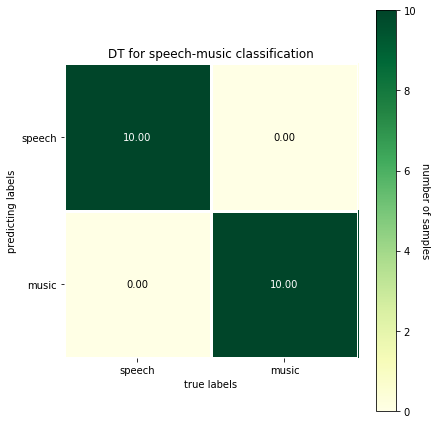

In [6]:
# YOUR CODE HERE
# raise NotImplementedError()
from sklearn.tree import DecisionTreeClassifier

sm_dt = DecisionTreeClassifier(random_state=0)
x, y = [], []
for i, t in enumerate(types):
    d = sm_classifiers[t].train_data
    x.append(d)
    y.append(np.ones(len(d)) * i)
x = np.vstack(tuple(x))
y = np.concatenate(tuple(y))
sm_dt.fit(X=x, y=y);

conf_mat = np.zeros((len(types), len(types)))
for i, t in enumerate(types):
    test_data = sm_classifiers[t].test_data
    for d in test_data:
        y_pred = sm_dt.predict(d).astype(int)
        j = np.bincount(y_pred).argmax()
        conf_mat[i, j] += 1
        
plot_conf_mat(conf_mat, types, 'DT for speech-music classification', size=6)

### Decision Tree for music genres classification

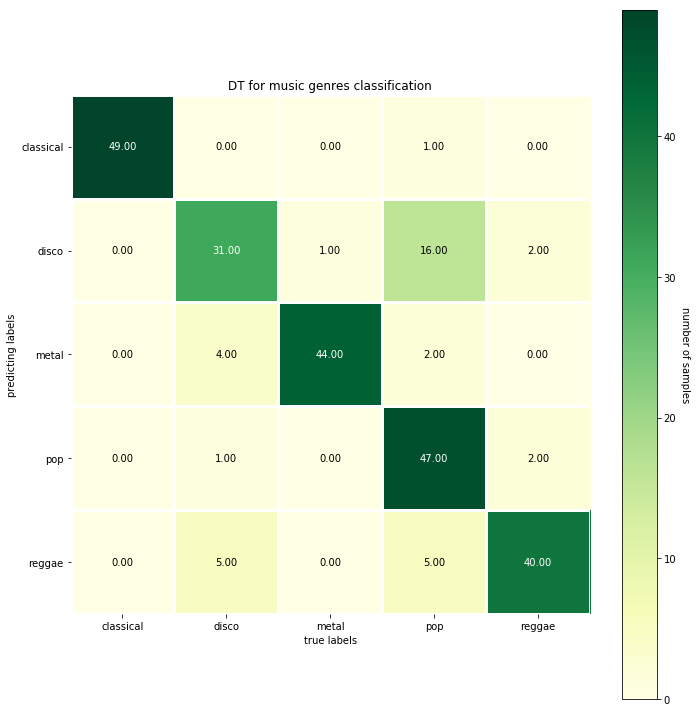

In [16]:
from sklearn.tree import DecisionTreeClassifier

g_dt = DecisionTreeClassifier(random_state=0)
x, y = [], []
for i, g in enumerate(genres):
    d = g_classifiers[g].train_data
    x.append(d)
    y.append(np.ones(len(d)) * i)
x = np.vstack(tuple(x))
y = np.concatenate(tuple(y))
g_dt.fit(X=x, y=y);

conf_mat = np.zeros((len(genres), len(genres)))
for i, g in enumerate(genres):
    test_data = g_classifiers[g].test_data
    for d in test_data:
        y_pred = g_dt.predict(d).astype(int)
        j = np.bincount(y_pred).argmax()
        conf_mat[i, j] += 1
        
plot_conf_mat(conf_mat, genres, 'DT for music genres classification', size=10)

As we can see, Decision Tree improves the accuracy for speech-music classification. For genres classification, the result is as good as GMM.